<a href="https://colab.research.google.com/github/iammuhammad41/Attention-Augmented-Convolutional-Networks-AConv-/blob/main/cnn-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pretrainedmodels albumentations

Notebook color scheme


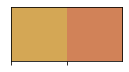

In [ ]:
from typing import Any, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as td
import pytorch_lightning as pl
import torchmetrics
import pretrainedmodels
import wandb
import os
import sys
import warnings
import random


from PIL import Image, ImageFile, ImageColor
from sklearn.model_selection import train_test_split
from colorama import Fore, Style
from tqdm import tqdm
from collections import defaultdict

from IPython.display import display_html, display_markdown, display_latex

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size':16})

os.environ['WANDB_SILENT'] = 'true'
CONFIG = {"competetion":"Muffin_Chihuaha", "_wandb_kernel":"aot"}

class clr:
    S = Style.BRIGHT + Fore.LIGHTRED_EX
    E = Style.RESET_ALL

spec_colors = ["#d4a755", "#d18258"]
MY_CMAP = ListedColormap(spec_colors)
print(clr.S+"Notebook color scheme"+clr.E)
sns.palplot(sns.color_palette(spec_colors))
plt.show()

warnings.filterwarnings('ignore')

In [ ]:
def build_metadata(path: str) -> pd.DataFrame:

    data = defaultdict(lambda: list())
    for label in os.listdir(path):
        for img_path in os.listdir(os.path.join(path, label)):
            data["img"].append(os.path.join(path, label, img_path))
            data["label"].append(label)

    data = pd.DataFrame.from_dict(data)
    data = data.sample(frac=1)
    return data

In [ ]:
df_train = build_metadata("/content/input/muffin-vs-chihuahua-image-classification/train")
df_test = build_metadata("/content/input/muffin-vs-chihuahua-image-classification/test")

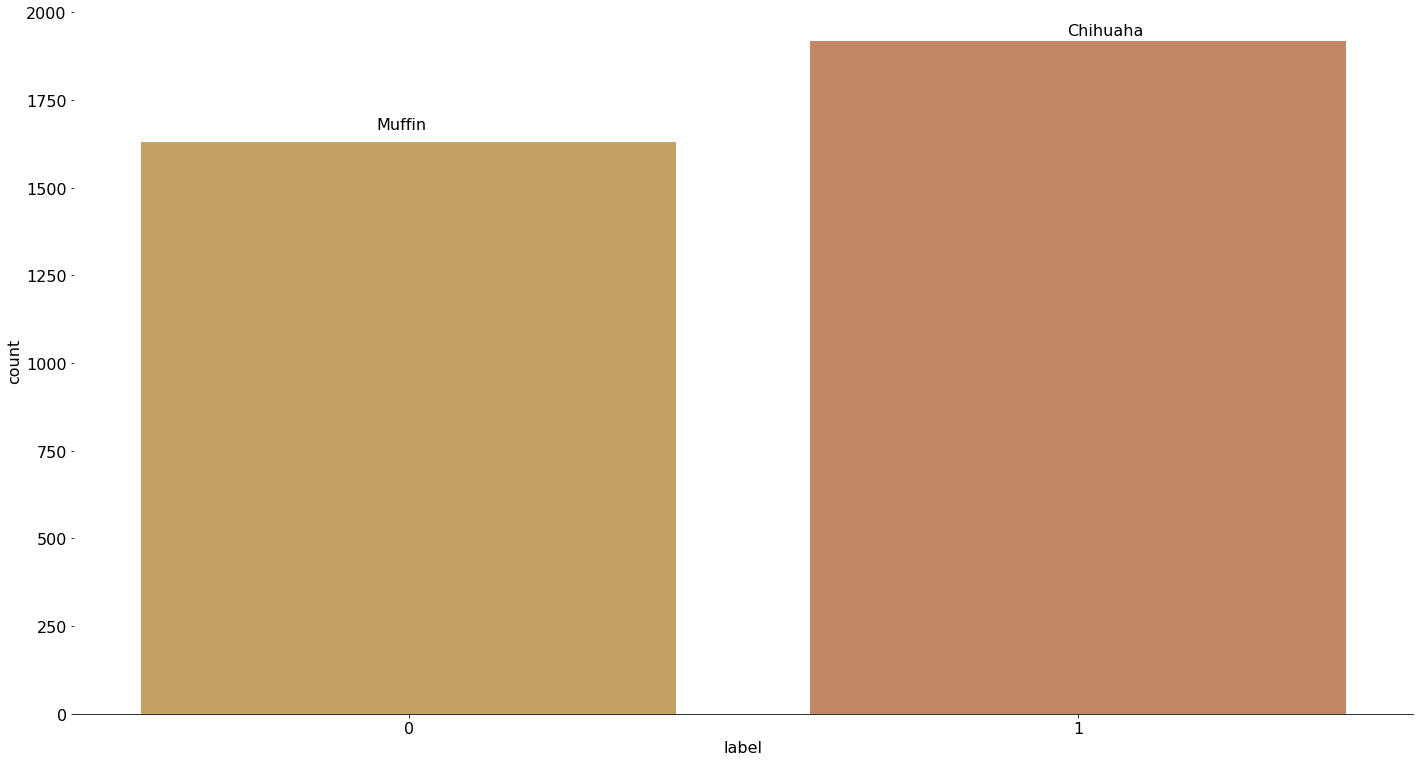

In [ ]:
plt.figure(figsize=(24, 13))
sns.countplot(x="label", data=df_train, palette=spec_colors)
sns.despine(right=True, top=True, left=True)
plt.figtext(0.3, 0.75, "Muffin")
plt.figtext(0.7, 0.85, "Chihuaha")
plt.show()

In [ ]:
labels = {'muffin':0, 'chihuahua':1}
df_train['label'] = df_train['label'].map(labels)
df_test['label'] = df_test['label'].map(labels)

In [ ]:
class ImageDataset(td.Dataset):
    def __init__(self, img_paths:str, labels:str, resize:tuple=None, augmentations=None):


        self.img_paths = img_paths
        self.labels = labels
        self.resize = resize
        self.augment = augmentations

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, item):

        img = Image.open(self.img_paths[item])
        img = img.convert("RGB")
        target = self.labels[item]

        if self.resize is not None:
            img = img.resize(
                (self.resize[1], self.resize[0]),
                resample = Image.Resampling.BILINEAR
            )

        img = np.array(img)

        if self.augment is not None:
            augmented = self.augment(image=img)
            img = augmented["image"]


        # As pytorch expects CHW instead of HWC
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)

        return {
            "image": torch.tensor(img, dtype=torch.float),
            "target": torch.tensor(target, dtype=torch.long)
        }



class ImageDataLoader(pl.LightningDataModule):
    def __init__(self, data:pd.DataFrame, batch_size:int, resize: tuple=None, augment=None):

        super().__init__()

        self.batch_size = batch_size
        self.augment = augment
        self.resize = resize
        self.data = data

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage:str):

        if stage not in ["train", "val", "test"]:
            raise Exception(f"Excepted stage value to be either train/val/test. Found {stage}")

        if stage == "train":
            self.train = ImageDataset(self.data["img"].to_list(),
                                     self.data["label"].to_list(), resize=self.resize, augmentations=self.augment)

        elif stage == "val":
            self.val = ImageDataset(self.data["img"].to_list(),
                                   self.data["label"].to_list(), resize=self.resize, augmentations=self.augment)

        else:
            self.test = ImageDataset(self.data["img"].to_list(),
                                    self.data["label"].to_list(), resize=self.resize, augmentations=self.augment)

    def train_dataloader(self) -> td.DataLoader:
        return td.DataLoader(
            self.train,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )

    def val_dataloader(self) -> td.DataLoader:
        return td.DataLoader(
            self.val,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 4
        )

    def test_dataloader(self) -> td.DataLoader:
        return td.DataLoader(
            self.test,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 4
        )


In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.SiLU()

        )

        self.conv2 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.SiLU()
        )

        self.conv3 = nn.Sequential(
            nn.LazyConv2d(128, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d()
        )


        self.max_pool = nn.MaxPool2d(kernel_size=1, stride=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=1)
        self.attn_conv = nn.LazyConv2d(128, kernel_size=1, stride=1)
        self.adapt_avg_pool = nn.AdaptiveAvgPool2d((8, 8))

        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(1)

    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)

        # Spatial Attention
        maxp_x = self.max_pool(x)
        avgp_x = self.avg_pool(x)

        spat_attn = self.attn_conv(torch.cat([maxp_x, avgp_x], dim=1))
        new_x = torch.mul(spat_attn, x)
        new_x = self.adapt_avg_pool(new_x)
        new_x = F.silu(x)

        feat = self.flatten(new_x)
        feat = self.fc1(feat)
        feat = F.silu(feat)
        feat = self.fc2(feat)

        return feat

    def compute_loss(self, yhat, y):
        y = y.reshape(-1, 1)
        return F.binary_cross_entropy_with_logits(yhat, y)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['target']
        yhat = self(x)

        loss = self.compute_loss(yhat, y.type_as(yhat))
        auc = torchmetrics.AUROC(task='binary')(yhat, y)

        self.log("train_loss", loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log("train_auc", auc, prog_bar=False, on_epoch=True, logger=True, on_step=False)

        return {'loss':loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch['image'], batch['target']
        yhat = self(x)

        loss = self.compute_loss(yhat, y.type_as(yhat))
        auc = torchmetrics.AUROC(task='binary')(yhat, y)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log("val_auc", auc, prog_bar=False, on_epoch=True, logger=True, on_step=False)

        return {'val_loss':loss}

    def test_step(self, batch, batch_idx):
        x, y = batch['image'], batch['target']
        yhat = self(x)

        loss = self.compute_loss(yhat, y.type_as(yhat))
        auc = torchmetrics.AUROC(task='binary')(yhat, y)

        self.log("test_loss", loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log("test_auc", auc, prog_bar=False, on_epoch=True, logger=True, on_step=False)

        return {'test_loss':loss}

    def predict_step(self, batch):
        x, y = batch['image'], batch.get('target', None)
        yhat = self(x)

        return {
            "predictions":yhat.detach().cpu().numpy()
        }

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 100, eta_min=1e-5)
        return {
            "optimizer":optimizer,
            "scheduler":scheduler
        }


In [ ]:
torch.cuda.empty_cache()


df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42, stratify=df_train['label'])

train_augmentations = albumentations.Compose([
    albumentations.Normalize(always_apply=True),
])

val_test_augmentations = albumentations.Compose([
    albumentations.Normalize(always_apply=True),
])

train_dm = ImageDataLoader(df_train, 16, resize=(256, 256), augment=train_augmentations)
val_dm = ImageDataLoader(df_val, 256, resize=(256, 256), augment=val_test_augmentations)
test_dm = ImageDataLoader(df_test, 256, resize=(256, 256), augment=val_test_augmentations)


train_dm.setup(stage="train")
val_dm.setup(stage="val")
test_dm.setup(stage="test")

train_dl = train_dm.train_dataloader()
val_dl = val_dm.val_dataloader()
test_dl = test_dm.test_dataloader()

early_stop = pl.callbacks.EarlyStopping(monitor="val_loss",
                                        patience=5,
                                        mode="min",
                                        verbose=True)

trainer = pl.Trainer(devices=1,
                     accelerator="gpu",
                     precision=16,
                     callbacks=[early_stop],
                     max_epochs=100,
                     gradient_clip_val=2)

In [ ]:
model = Model()
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model2 = Model.load_from_checkpoint("/content/input/lightning_logs/version_0/checkpoints/epoch=15-step=3552.ckpt")
model2.eval()

Model(
  (conv1): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): SiLU()
  )
  (conv2): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): SiLU()
  )
  (conv3): Sequential(
    (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (max_pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=1, stride=1, padding=0)
  (attn_conv): LazyConv2d(0, 128, kernel_size=(1, 1), stride=(1, 1))
  (adapt_avg_pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (flatten): Flat

In [ ]:
def predict(model, data) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        if isinstance(data, td.DataLoader):

            preds = list()

            for batch in tqdm(data):
                x = batch['image']
                yhat = F.sigmoid(model(x))

                preds.append(yhat.detach().cpu())

            preds = torch.vstack(preds)
            return preds.numpy()



        else:
            return F.sigmoid(model(data)).detach().cpu().numpy()

In [ ]:
test_preds = predict(model2, test_dl)

100%|██████████| 5/5 [00:34<00:00,  6.89s/it]


In [ ]:
test_preds = np.where(test_preds >= 0.5, 1, 0).flatten()
test_preds

array([1, 1, 0, ..., 0, 1, 0])

In [ ]:
test_acc = np.mean(test_preds == df_test['label'].values) * 100

print(clr.S+"Test Accuracy : "+clr.E+str(np.round(test_acc, 2))+"%")

Test Accuracy : 90.2%


In [ ]:
def custom_img_pred(model: pl.LightningModule, path: str) -> str:

    img = Image.open(path)
    img = img.convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    img = img.resize((256, 256), resample=Image.Resampling.BILINEAR)
    img = np.array(img)
    aug = val_test_augmentations(image=img)
    img = aug["image"]
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)
    img = torch.tensor(img, dtype=torch.float)
    img = img.unsqueeze_(0) # To represent it as a batch image
    pred = predict(model, img)

    if pred >= 0.5:
        return clr.S+"This is a Chihuaha"+clr.E+"\n\n"
    else:
        return clr.S+"This is a Muffin"+clr.E+"\n\n"

This is a Muffin




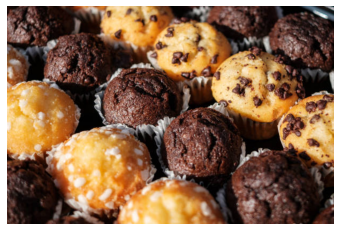

In [ ]:
print(custom_img_pred(model2, "/content/input/custom-muffin-chihuaha-image/istockphoto-1089505944-612x612.jpg"))

This is a Chihuaha




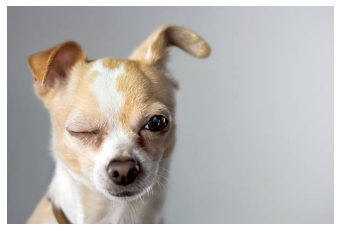

In [ ]:
print(custom_img_pred(model2, "/content/input/custom-muffin-chihuaha-image/istockphoto-147680232-612x612.jpg"))